# Introduction

This notebook trains and tests the probabilistic models for presence and harmful concentration (HA). The evaluation graphs and table with scores, model response to environmental factors, and change in the score regarding increasing sanitary thresholds are all computed here. It saves the figures, models, and predicted presence probability.

# 0. Library

In [1]:
from sklearn.calibration import calibration_curve
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import os
import copy as cp
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.metrics import make_scorer
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Input path files

In [2]:
# Paths
path = os.getcwd()

# Path for the HAB database
path_hab = os.path.join(path, "00_database", "db.csv")

# Path to save the CSV files with predicted values
path_out_pred = os.path.join(path, "00_database", "presence_db_pred.csv")

# Path for saving the calibrated models
path_out_alg = os.path.join(path, "00_output", "01_ml_models")

# Path for saving figures
path_out_fig = os.path.join(path, "00_figures")

# 2. Parameters and model configuration

In [3]:
# Predictors to train the model
predictors = ["sst", "mld", "sss", "par"]

# Species to be the target of the models
spec_list = [
    "A. sp.",
    'A. tamarense',
    'D. acuta',
    'D. acuminata',
    "D. norvegica",
    "Pn. sp.",
    "P. reticulatum",
    "A. spinosum"
]

# Years interval to train the model (train dataset)
year_train_min, year_train_max = 2006, 2013

# Years interval to test the model (test dataset)
year_test_min, year_test_max = 2014, 2019

# Harmful abundance thresholds
hab_th = {
    "D. acuminata": 1000,
    "D. acuta": 200,
    "A. tamarense": 200,
    "D. norvegica": 4000,
    "Pn. sp.": 1000000,
    "P. reticulatum": 1000,
    "A. sp.": 200,
    "A. spinosum": 3600
}

# Presence thresholds
presence_th = {
    "D. acuminata": 1,
    "D. acuta": 1,
    "A. tamarense": 1,
    "D. norvegica": 1,
    "Pn. sp.": 1,
    "P. reticulatum": 1,
    "A. sp.": 1,
    "A. spinosum": 1
}

# SVM hyperparameters (it obtained from tuning, here is used "standard" values)
C, gamma, kernel = 1, "scale", "rbf"
class_weight, probability, max_iter = "balanced", True, -1
random_state = 66 # only used for the main model

# Labels to plot
var_labels = {
    "sst": "SST (°C)",
    "mld": "MLD (m)",
    "par": "PAR (E m$^{-2}$ d$^{-1}$)",
    "sss": "SSS (PSU)"
}

# Error (fraction) of each input variable to add and simulate noise
var_errors = {"sst": 0.4, "mld": 10, "par": 5.7, "sss": 0.3}


# 3. Customs scores to evaluate the models

It includes reliability correlation (R), root mean squared error (RMSE), and Average bias (AB)

In [4]:
def reliability_r(y_true, y_pred):
    event_freq, prob_pred = calibration_curve(y_true, y_pred,
                                              strategy="quantile",
                                              n_bins=10)
    r, _ = pearsonr(event_freq, prob_pred)
    return r

def reliability_pvalue(y_true, y_pred):
    _, pvalue = pearsonr(*calibration_curve(y_true, y_pred,
                                            strategy="quantile",
                                            n_bins=10))
    return pvalue

def reliability_rmse(y_true, y_pred):
    event_freq, prob_pred = calibration_curve(y_true, y_pred,
                                              strategy="quantile",
                                              n_bins=10)
    rmse = np.sqrt(np.mean((event_freq - prob_pred) ** 2))
    return rmse

def reliability_avgbias(y_true, y_pred):
    event_freq, prob_pred = calibration_curve(y_true, y_pred,
                                              strategy="quantile",
                                              n_bins=10)
    avg_bias = np.mean((prob_pred - event_freq))
    return avg_bias

# Scoring functions
reliability_r_scorer = make_scorer(reliability_r, greater_is_better=True, needs_proba=True)
reliability_pvalue_scorer = make_scorer(reliability_pvalue, greater_is_better=False, needs_proba=True)
reliability_rmse_scorer = make_scorer(reliability_rmse, greater_is_better=False, needs_proba=True)
reliability_avgbias_scorer = make_scorer(reliability_avgbias, greater_is_better=False, needs_proba=True)


# 4. Read data

In [5]:
df_all = pd.read_csv(path_hab, index_col=["Region", 0])

dates = pd.to_datetime(df_all.index.get_level_values(1))

In [6]:
df_all.head(3)

A. sp.  A. tamarense  D. acuta  D. acuminata  \
Region   Date                                                       
Grimstad 2017-02-20       0             0         0             0   
         2017-02-27       0             0         0             0   
         2017-03-06       0             0         0            40   

                     D. norvegica  Pn. sp.  P. reticulatum  A. spinosum  \
Region   Date                                                             
Grimstad 2017-02-20             0      0.0               0          0.0   
         2017-02-27             0  60000.0               0          0.0   
         2017-03-06             0      0.0               0          0.0   

                          sst        par        mld        sss  
Region   Date                                                   
Grimstad 2017-02-20  5.103785  10.172082  26.137764  33.355826  
         2017-02-27  3.935072  10.872102  31.656046  32.705138  
         2017-03-06  3.625521   9.677708  43.847600  31.418279

# 5. Subsets for presence and harmful abundance split into train and test

In [7]:
# Create the HA observation table
hab_dict = {spec: (df_all[spec] >= hab_th[spec]).astype(int).values for spec in hab_th.keys()}

df_hab = pd.DataFrame(hab_dict, index=df_all.index)
df_hab = df_hab.join(df_all[["sst", "par", "mld", "sss"]])

df_hab_train = df_hab[(dates.year >= year_train_min) & (dates.year <= year_train_max)]
df_hab_test = df_hab[(dates.year >= year_test_min) & (dates.year <= year_test_max)]

# Create the presence observation table
presence_dict = {spec: (df_all[spec] >= presence_th[spec]).astype(int).values for spec in presence_th.keys()}

df_presence = pd.DataFrame(presence_dict, index=df_all.index)
df_presence = df_presence.join(df_all[["sst", "par", "mld", "sss"]])

df_presence_train = df_presence[(dates.year >= year_train_min) & (dates.year <= year_train_max)]
df_presence_test = df_presence[(dates.year >= year_test_min) & (dates.year <= year_test_max)]


# 6. Train the models

## 6.1 Presence model

In [8]:
presence_models = {}
for target in spec_list:
    # Set pre-process functions to the model
    scaler = StandardScaler()
    pca = PCA()

    # Set the SVM model
    model = SVC(
        C=C,
        gamma=gamma,
        kernel=kernel,
        class_weight=class_weight,
        probability=1,
        max_iter=max_iter,
        random_state=random_state
    )

    # Set the pipeline
    pipe = Pipeline(
        steps=[("scaler", scaler),
               ("pca", pca),
               ("model", model)]
    )

    # Fit the pipe (and model)
    pipe.fit(
        X=df_presence_train.loc[:, predictors],
        y=df_presence_train.loc[:, target]
    )

    # Predict the test dataset
    presence_pred_array = pipe.predict_proba(df_presence_test.loc[:, predictors])[:, 1]
    presence_pred_df_spec = pd.DataFrame(
        presence_pred_array, index=df_presence_test.index, columns=[target]
    )

    # Save predicted values in a table
    if target == spec_list[0]:
        presence_pred_df = presence_pred_df_spec
    else:
        presence_pred_df = presence_pred_df.join(presence_pred_df_spec)

    # Save the model in a dictionary
    presence_models[target] = pipe

# Save the model to a pickle file
with open(os.path.join(path_out_alg, "ml_dict.pickle"), 'wb') as handle:
    pickle.dump(presence_models, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the predicted data
presence_pred_df.to_csv(path_out_pred)


## 6.2 HA model

In [9]:
hab_models = {}
for target in spec_list:
    # Set pre-process functions to the model
    scaler = StandardScaler()
    pca = PCA()

    # Set the SVM model
    model = SVC(
        C=C,
        gamma=gamma,
        kernel=kernel,
        class_weight=class_weight,
        probability=1,
        max_iter=max_iter,
        random_state=random_state
    )

    # Set the pipeline
    pipe = Pipeline(
        steps=[("scaler", scaler),
               ("pca", pca),
               ("model", model)]
    )

    # Fit the pipe (and model)
    pipe.fit(
        X=df_hab_train.loc[:, predictors],
        y=df_hab_train.loc[:, target]
    )

    # Predict the test dataset
    hab_pred_array = pipe.predict_proba(df_hab_test.loc[:, predictors])[:, 1]
    hab_pred_df_spec = pd.DataFrame(
        hab_pred_array, index=df_hab_test.index, columns=[target]
    )

    # Save predicted values in a table
    if target == spec_list[0]:
        hab_pred_df = hab_pred_df_spec
    else:
        hab_pred_df = hab_pred_df.join(hab_pred_df_spec)

    # Save the model in a dictionary
    hab_models[target] = pipe

# Save the model to a pickle file
with open(os.path.join(path_out_alg, "ml_dict_hab.pickle"), 'wb') as handle:
    pickle.dump(hab_models, handle, protocol=pickle.HIGHEST_PROTOCOL)


# 7. Simulate uncertainty

## 7.1 SVM model uncertainty

In [10]:
presence_modelunc_dict = {}

# Iterate to estimate prediction variances as a response to model recalibration
for i in range(0, 100):
    for target in spec_list:
        
        # Set pre-process functions to the model
        scaler = StandardScaler()
        pca = PCA()

        # Set the SVM model
        model = SVC(
            C=C,
            gamma=gamma,
            kernel=kernel,
            class_weight=class_weight,
            probability=1,
            max_iter=max_iter
        )

        # Set the pipeline
        pipe = Pipeline(
            steps=[("scaler", scaler),
                   ("pca", pca),
                   ("model", model)]
        )

        # Resample a 2/3 subset
        subset = resample(df_presence_train, n_samples=int(len(df_presence_train) * 0.66))

        # Fit the pipe (and model)
        pipe.fit(
            X=subset.loc[:, predictors],
            y=subset.loc[:, target]
        )

        # Predict the test dataset
        presence_pred_array = pipe.predict_proba(df_presence_test.loc[:, predictors])[:, 1]
        presence_pred_df_spec = pd.DataFrame(
            presence_pred_array, index=df_presence_test.index, columns=[target]
        )

        # Save predicted values in a table
        if target == spec_list[0]:
            presence_pred_df_i = presence_pred_df_spec
        else:
            presence_pred_df_i = presence_pred_df_i.join(presence_pred_df_spec)

    # Save the predicted data to a dictionary
    presence_modelunc_dict[i] = presence_pred_df_i

## 7.2 Input model uncertainty

In [11]:
presence_inputunc_iter = {}

for i in range(0, 100):
            
    # Set a subset of predictors to add the error
    X = cp.copy(df_presence_test.loc[:, predictors])

    # Create the noise df
    for var in ["sst", "mld", "sss", "par"]:
        noise = np.random.normal(0, var_errors[var], len(X[var]))

        # Add noise
        X[var] = X[var] + noise


    for target in spec_list:
        # Select the model
        pipe_model = presence_models[target]

        # Predict the test dataset
        presence_pred_array = pipe_model.predict_proba(X.loc[:, predictors])[:, 1]
        presence_pred_df_spec = pd.DataFrame(
            presence_pred_array, index=df_presence_test.index, columns=[target]
        )

        # Save predicted values in a table
        if target == spec_list[0]:
            presence_pred_df_i = presence_pred_df_spec
        else:
            presence_pred_df_i = presence_pred_df_i.join(presence_pred_df_spec)

    presence_inputunc_iter[i] = presence_pred_df_i


# 8. Plot reliability diagram

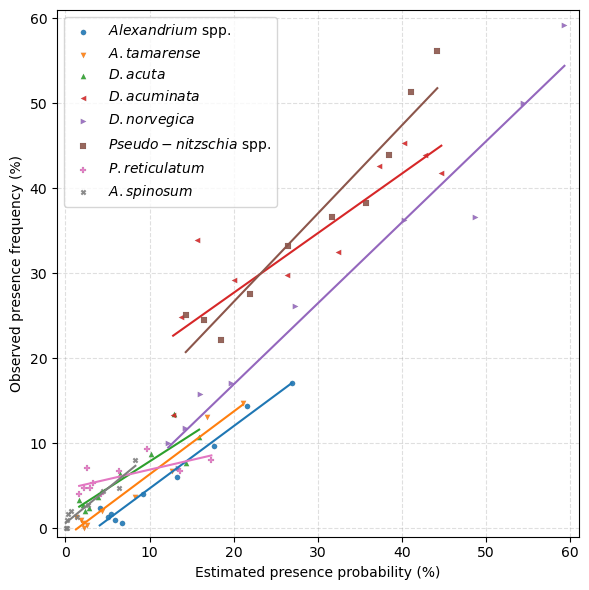

In [12]:
marker_styles = ['o', 'v', '^', '<', '>', 's', "P", 'X'][:len(spec_list)]
fig, ax = plt.subplots(figsize=(6, 6))

i = 0
for spec in spec_list:
    # Subset
    y_true = df_presence_test[spec]
    y_pred = presence_pred_df[spec]

    # Compute reliability diagram
    reliability_array = calibration_curve(y_true, y_pred, strategy="quantile", n_bins=10)

    df_reliability = pd.DataFrame(reliability_array, index=["Observed presence frequency (%)", "Estimated presence probability (%)"]).T
    df_reliability = df_reliability * 100  # Convert to %

    # Plot
    sns.regplot(x="Estimated presence probability (%)",
                y="Observed presence frequency (%)",
                data=df_reliability,
                label=spec,
                ci=None,
                scatter_kws={"s": 15, "edgecolor": "k", "linewidth": 0.05, "alpha": 0.9},
                line_kws={"linewidth": 1.5},
                marker=marker_styles[i], ax=ax)

    i += 1

# Change ticks and labels
ax.set_xlim((-1, 61))
ax.set_ylim((-1, 61))

# Add grid
ax.grid(linestyle="--", color="grey", alpha=0.25)

# Edit legend
ax.legend(loc='upper left')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["$\it{Alexandrium}$ spp.",
                    "$\it{A. tamarense}$",
                    "$\it{D. acuta}$",
                    "$\it{D.acuminata}$",
                    "$\it{D. norvegica}$",
                    "$\it{Pseudo-nitzschia}$ spp.",
                    "$\it{P. reticulatum}$",
                    "$\it{A. spinosum}$"])
#ax.set_title("Presence Models")
plt.tight_layout()
# Save fig
fig.savefig(path_out_fig + "/prob_x_event.png", dpi=300)


# 9. Statistics for all models

## 9.1 Presence models

In [13]:
presencestat_dict = {}

for spec in spec_list:
    # Subset
    y_true = df_presence_test[spec]
    y_pred = presence_pred_df[spec]

    # Presence statistics
    r = np.round(reliability_r(y_true, y_pred), 2)
    pvalue = np.round(reliability_pvalue(y_true, y_pred), 2)
    rmse = np.round(reliability_rmse(y_true, y_pred) * 100, 2)
    avg_bias = reliability_avgbias(y_true, y_pred) * 100
    min_perc = np.round(y_pred.min() * 100, 2)
    max_perc = np.round(y_pred.max() * 100, 2)

    # Populate presence statistics dictionary
    presencestat_dict[spec] = r, pvalue, rmse, avg_bias, min_perc, max_perc

# Create DataFrame for presence statistics
df_presencestat_ref = pd.DataFrame(presencestat_dict.values(),
                                   index=presencestat_dict.keys(),
                                   columns=["R",
                                            "P-value",
                                            "RMSE (%)",
                                            "AB (%)",
                                            "Min. predicted (%)",
                                            "Max. predicted (%)"])

In [14]:
df_presencestat_ref

,R,P-value,RMSE (%),AB (%),Min. predicted (%),Max. predicted (%)
A. sp.,0.98,0.00,6.16,5.736979,2.76,37.19
A. tamarense,0.98,0.00,3.60,2.965903,0.58,35.02
D. acuta,0.90,0.00,2.77,1.137199,0.96,18.64
D. acuminata,0.87,0.00,7.84,-5.152765,8.12,47.90
D. norvegica,0.98,0.00,4.91,3.554254,9.66,69.45
Pn. sp.,0.96,0.00,7.62,-7.000006,9.77,48.56
P. reticulatum,0.69,0.03,4.17,0.315088,0.67,24.90
A. spinosum,0.96,0.00,0.84,-0.137414,0.01,14.46


## 9.2 Input uncertainty

In [15]:
presencestat_dict_iter = {}
    
for i in range(1, 100):

    presencestat_dict = {}
    for spec in spec_list:

        # Subset
        y_true = df_presence_test[spec]
        y_pred = presence_inputunc_iter[i][spec]


        # Presence statistics
        r = np.round(reliability_r(y_true, y_pred), 2)
        pvalue = np.round(reliability_pvalue(y_true, y_pred), 2)
        rmse = np.round(reliability_rmse(y_true, y_pred) * 100, 2)
        avg_bias = reliability_avgbias(y_true, y_pred) * 100
        min_perc = np.round(y_pred.min() * 100, 2)
        max_perc = np.round(y_pred.max() * 100, 2)

        # Populate presence statistics dictionary
        presencestat_dict[spec] = r, pvalue, rmse, avg_bias, min_perc, max_perc

    # Create DataFrame for presence statistics
    df_presencestat = pd.DataFrame(presencestat_dict.values(),
                                   index=presencestat_dict.keys(),
                                   columns=["R",
                                            "P-value",
                                            "RMSE (%)",
                                            "AB (%)",
                                            "Min. predicted (%)",
                                            "Max. predicted (%)"])

    df_presencestat_diff = df_presencestat #- df_presencestat_ref

    presencestat_dict_iter[i] = df_presencestat_diff


In [17]:
for i in range(1, 100):

    df_stats_R_i = presencestat_dict_iter[i][["R"]].T
    df_stats_RMSE_i = presencestat_dict_iter[i][["RMSE (%)"]].T
    df_stats_AB_i = presencestat_dict_iter[i][["AB (%)"]].T

    if i == 1:
        df_stats_R = df_stats_R_i
        df_stats_RMSE = df_stats_RMSE_i
        df_stats_AB = df_stats_AB_i

    else:
        df_stats_R = pd.concat((df_stats_R, df_stats_R_i))
        df_stats_RMSE = pd.concat((df_stats_RMSE, df_stats_RMSE_i))
        df_stats_AB = pd.concat((df_stats_AB, df_stats_AB_i))

list_stats = [df_stats_R, df_stats_RMSE, df_stats_AB]

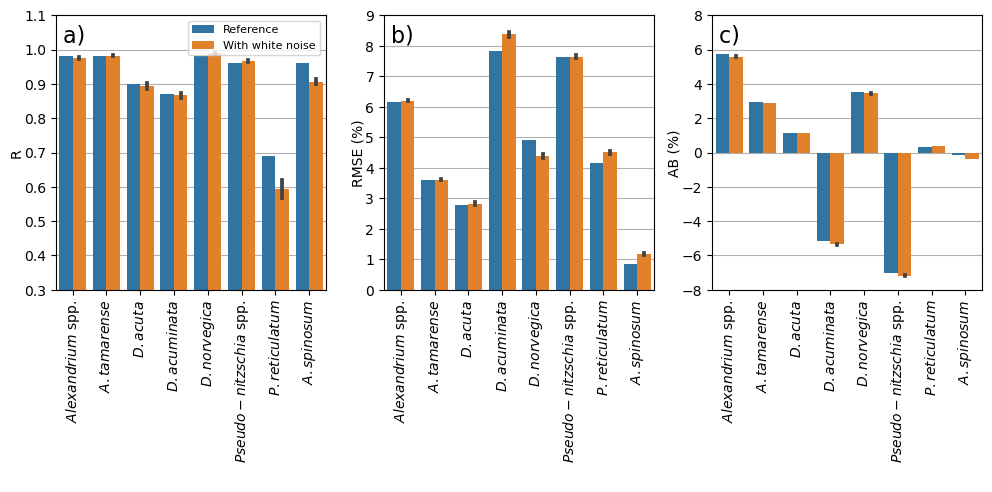

In [18]:
ylim_dict = {
    "R" : (0.3, 1.1),
    "RMSE (%)" : (0, 9),
    "AB (%)": (-8, 8)
}

fig = plt.figure(figsize=(10, 5))
i = 1

for j, stat_j in enumerate(["R", "RMSE (%)", "AB (%)"]):
    if j == 0:
        leg = True
    else:
        leg = False
            
    # Subset data
    subset = list_stats[j]
    subset["Group"] = "With white noise"
    subset_ref = df_presencestat_ref[[stat_j]].T
    subset_ref["Group"] = "Reference"
    subset = pd.concat([subset, subset_ref])
    #
    subset = pd.melt(subset, var_name="Taxa", value_name=stat_j, id_vars=["Group"])
    
    # Plot
    ax = plt.subplot(1, 3, i)
    sns.barplot(y=stat_j,
                x="Taxa",
                hue="Group",
                hue_order=["Reference", "With white noise"],
                data=subset,
                linewidth=0.3,
                #fliersize=1,
                ax=ax)
    
    # Customize plot
    ax.legend(ncol=1, loc="upper right", fontsize=8).set_visible(leg)
    ax.tick_params(axis="x", rotation=90)
    ax.set_xticklabels(["$\it{Alexandrium}$ spp.",
                        "$\it{A. tamarense}$",
                        "$\it{D. acuta}$",
                        "$\it{D.acuminata}$",
                        "$\it{D. norvegica}$",
                        "$\it{Pseudo-nitzschia}$ spp.",
                        "$\it{P. reticulatum}$",
                        "$\it{A. spinosum}$"])
    
    ax.set_ylabel(stat_j, labelpad=0)
    ax.set_xlabel(" ")
    ax.set_xlim((-0.5, 7.5))
    ax.set_ylim(ylim_dict[stat_j])
    ax.grid(axis="y")
    ax.set_axisbelow(True)

    ax.text(-0.3,
            ((ylim_dict[stat_j][1] - ylim_dict[stat_j][0]) * 0.9) + ylim_dict[stat_j][0],
            chr(ord('`') + i) + ") ",
            fontsize=16)
    
    #if i < 3:
     #   ax.set_xticklabels("")
        
    i += 1


plt.tight_layout(pad=1)
fig.savefig(path_out_fig + "/data_uncertainty.png", dpi=300)


## 9.3 Model uncertainty

In [19]:
# statistics for distributions
presencestat_dict_iter = {}

for i in range(0, 100):
    presencestat_dict = {}
    for spec in spec_list:
        # Subset
        y_true = df_presence_test[spec]
        y_pred = presence_modelunc_dict[i][spec]

        # Presence statistics
        r = np.round(reliability_r(y_true, y_pred), 2)
        pvalue = np.round(reliability_pvalue(y_true, y_pred), 2)
        avg_bias = reliability_avgbias(y_true, y_pred) * 100
        rmse = np.round(reliability_rmse(y_true, y_pred) * 100, 2)
        min_perc = np.round(y_pred.min() * 100, 2)
        max_perc = np.round(y_pred.max() * 100, 2)


        # Populate presence statistics dictionary
        presencestat_dict[spec] = r, pvalue, rmse, avg_bias, min_perc, max_perc

    # Create DataFrame for presence statistics
    df_presencestat = pd.DataFrame(presencestat_dict.values(),
                                   index=presencestat_dict.keys(),
                                   columns=["R",
                                            "P-value",
                                            "RMSE (%)",
                                            "AB (%)",
                                            "Min. predicted (%)",
                                            "Max. predicted (%)"])
    
    df_presencestat_diff = df_presencestat#-df_presencestat_ref
    
    presencestat_dict_iter[i] = df_presencestat_diff


In [20]:
(subset[[stat_j]]-subset.groupby("Taxa").median()).reset_index()

,index,AB (%)
0,0,NaN
1,1,NaN
2,2,NaN
3,3,NaN
4,4,NaN
...,...,...
803,D. acuminata,NaN
804,D. acuta,NaN
805,D. norvegica,NaN
806,P. reticulatum,NaN


In [21]:
# Combine presence statistics for model uncertainty
for i in range(0, 100):
    if i == 0:
        subset = presencestat_dict_iter[i]
    else:
        subset = pd.concat([subset, presencestat_dict_iter[i]])

subset["Taxa"] = subset.index
stat_modelunc_df = subset


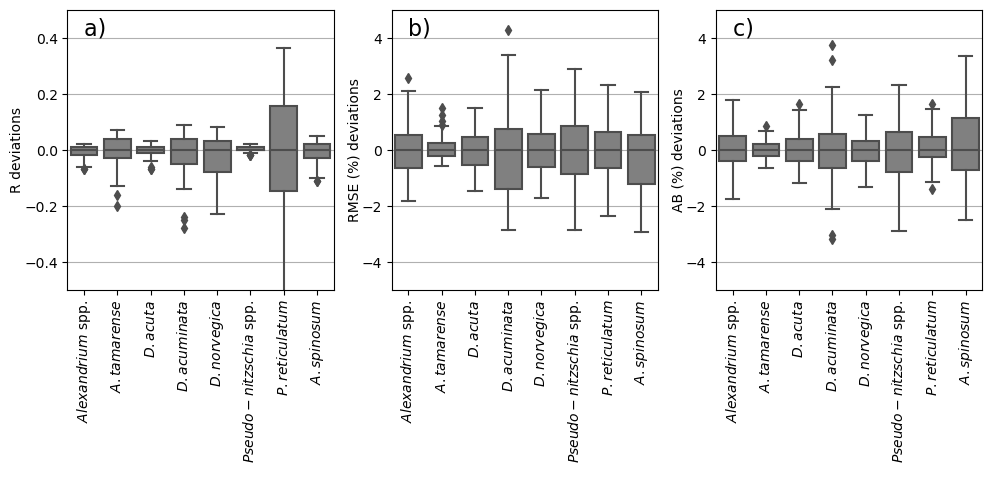

In [22]:
ylim_dict = {
    "R" : (-0.5, 0.5),
    "RMSE (%)" : (-5, 5),
    "AB (%)": (-5, 5)
}

fig = plt.figure(figsize=(10, 5))

i = 1
for j, stat_j in enumerate(["R", "RMSE (%)", "AB (%)"]):
    if j == 0:
        leg = True
    else:
        leg = False
    subset = stat_modelunc_df.loc[:, ["Taxa", stat_j]]
    subset = (subset[[stat_j]]-subset.groupby("Taxa").median()).reset_index()
    
    # Plot
    ax = plt.subplot(1, 3, i)
    sns.boxplot(y=stat_j,
                x="index",
                data=subset,
                color="grey",
                ax=ax)
    
    # Customize plot
    ax.tick_params(axis="x", rotation=90)
    ax.set_xticklabels(["$\it{Alexandrium}$ spp.",
                        "$\it{A. tamarense}$",
                        "$\it{D. acuta}$",
                        "$\it{D.acuminata}$",
                        "$\it{D. norvegica}$",
                        "$\it{Pseudo-nitzschia}$ spp.",
                        "$\it{P. reticulatum}$",
                        "$\it{A. spinosum}$"])
    
    ax.set_ylabel(stat_j, labelpad=0)
    ax.set_ylabel(stat_j + " deviations")
    ax.set_xlabel(" ")
    ax.set_ylim(ylim_dict[stat_j])
    ax.set_xlim((-0.5, 7.5))
    ax.text(0,
            ((ylim_dict[stat_j][1] - ylim_dict[stat_j][0]) * 0.91) + ylim_dict[stat_j][0],
            chr(ord('`') + i) + ") ",
            fontsize=16)
    ax.grid(axis="y")
    ax.set_axisbelow(True)

    i += 1
    
plt.tight_layout(pad=1)
fig.savefig(path_out_fig + "/model_uncertainty.png", dpi=300)

# 10. Simulate presence model response

In [23]:
# Create data to be the input of simulations
df_predpercentiles = df_presence_train[predictors].describe(percentiles=np.linspace(0.01, 1, 100)).loc["2%":"97%"]

dict_predtosimul = {}
for pred in predictors:
    
    df_predtosimul = df_predpercentiles.loc[:, [pred]]
    for pred_tomed in [x for x in predictors if x != pred]:
        df_predtosimul[pred_tomed] = df_predpercentiles.loc["50%", pred_tomed]
    df_predtosimul = df_predtosimul[predictors]
    
    dict_predtosimul[pred] = df_predtosimul


In [24]:
# Make the simulations
presencesimul_dict = {}
for pred in predictors:
    for spec in spec_list:
        pipe = presence_models[spec]

        # subset
        df_predtosimul = dict_predtosimul[pred]
        df_presencesimu_spec = pd.DataFrame(pipe.predict_proba(df_predtosimul)[:, 1],
                                            columns=[spec],
                                            index=df_predtosimul.index)
        
        # join simulations
        if spec == spec_list[0]:
            df_presencesimu = df_presencesimu_spec
        else:
            df_presencesimu = df_presencesimu.join(df_presencesimu_spec)
    
    # save simulations
    df_presencesimu = df_presencesimu.join(df_predpercentiles[pred])
    presencesimul_dict[pred] = df_presencesimu


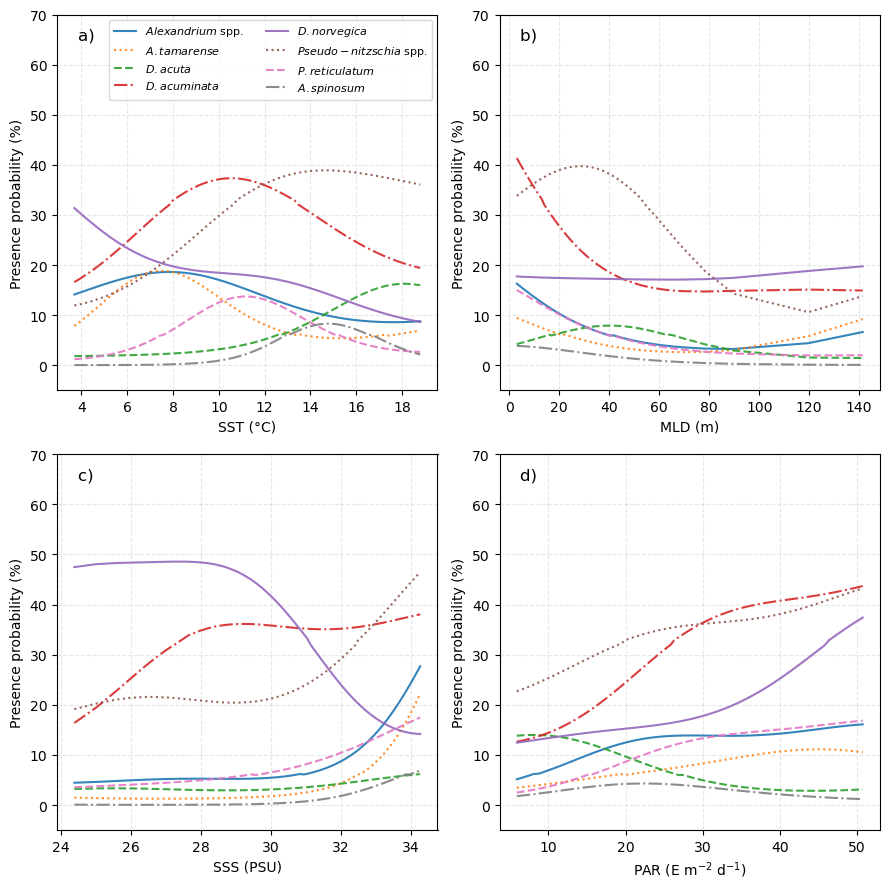

In [25]:
fig = plt.figure(figsize=(9, 9))

i = 1
for pred in predictors:
    # subset
    subset = cp.copy(presencesimul_dict[pred])
    subset[spec_list] = subset[spec_list] * 100
    
    if i == 1:
        leg = True
    else:
        leg = False
    
    # plot
    ax = plt.subplot(2, 2, i)
    subset.plot(x=pred,
                y=spec_list,
                style=["-", ":", "--", "-.", "-", ":", "--", "-."],
                ax=ax,
                ylim=(-5, 70),
                legend=leg,
                alpha=0.9)
    
    # edit legend
    if i == 1:
        ax.legend(loc='upper right', ncol=2)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, ["$\it{Alexandrium}$ spp.",
                            "$\it{A. tamarense}$",
                            "$\it{D. acuta}$",
                            "$\it{D.acuminata}$",
                            "$\it{D. norvegica}$",
                            "$\it{Pseudo-nitzschia}$ spp.",
                            "$\it{P. reticulatum}$",
                            "$\it{A. spinosum}$"],
                  ncol=2,
                  fontsize=8)
    
    # add grid, change labels, and add text
    ax.grid(linestyle="--", alpha=0.3)
    ax.set_ylabel("Presence probability (%)")
    ax.set_xlabel(var_labels[pred])
    ax.text(((subset[pred].max() - subset[pred].min()) * 0.01) + subset[pred].min(),
            65,
            chr(ord('`') + i) + ") ",
            fontsize=12)
    i = i + 1

# save figure
plt.tight_layout()
fig.savefig(path_out_fig + "/model_simulresponse.png", dpi=300)

# 11.  Statistic changes with increased sanitary thresholds

In [26]:
habstat_dict = {}

# iteract over species
for target in spec_list:
    # iteract over percentile to HC
    for th_perc in [0, 0.2, 0.4, 0.6, 0.8, 1]:
        th = 1 if th_perc == 0 else hab_th[target] * th_perc
        
        # subset hab adn environmental data
        hab_dict = {target: (df_all[target] >= th).astype(int).values}

        df_hab = pd.DataFrame(hab_dict.values(),
                              index=hab_dict.keys(),
                              columns=df_all.index).T

        df_hab = df_hab.join(df_all[["sst", "par", "mld", "sss"]])
        
        # split between train and test
        df_hab_train = df_hab[(dates.year >= year_train_min) & (dates.year <= year_train_max)]
        df_hab_test = df_hab[(dates.year >= year_test_min) & (dates.year <= year_test_max)]
        
        # configure pre-processing and SVM model in the pipeline
        scaler = StandardScaler()
        pca = PCA()
        model = SVC(
            C=C,
            gamma=gamma,
            kernel=kernel,
            class_weight=class_weight,
            probability=1,
            max_iter=max_iter,
            random_state=random_state
        )

        pipe = Pipeline(steps=[
            ("scaler", scaler),
            ("pca", pca),
            ("model", model)
        ])
        
        # fit the model
        pipe.fit(
            X=df_hab_train.loc[:, predictors],
            y=df_hab_train.loc[:, target]
        )
        
        # predicte the test data
        hab_pred_array = pipe.predict_proba(df_hab_test.loc[:, predictors])[:, 1]
        hab_pred_df_spec = pd.DataFrame(
            hab_pred_array,
            index=df_hab_test.index,
            columns=[target]
        )

        y_true = df_hab_test[target]
        y_pred = hab_pred_df_spec
        
        # compute statistics
        r = reliability_r(y_true, y_pred)
        min_perc = np.round(y_pred.min() * 100, 2)[0]
        max_perc = np.round(y_pred.max() * 100, 2)[0]
        r = np.round(r, 2)
        
        avg_bias = reliability_avgbias(y_true, y_pred) * 100

        rmse = np.round(reliability_rmse(y_true, y_pred) * 100, 2)
        rmse_norm = np.round((rmse / (max_perc - min_perc)) * 100, 2)
        event_freq = len(df_hab[df_hab[target] == 1])

        habstat_dict[target, th_perc] = (
            target,
            th_perc * 100,
            r,
            rmse_norm,
            avg_bias,
            event_freq
        )

# save all data in the same data frame
df_habstat = pd.DataFrame(
    habstat_dict.values(),
    index=habstat_dict.keys(),
    columns=[
        "Taxa",
        "Percentile to HAB",
        "R",
        "RMSE_norm",
        "AB",
        "Event frequency"
    ]
)


/tmp/ipykernel_68671/3736973184.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "Presence", 20, 40, 60, 80, "HA", ""])
/tmp/ipykernel_68671/3736973184.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "Presence", 20, 40, 60, 80, "HA", ""])
/tmp/ipykernel_68671/3736973184.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "Presence", 20, 40, 60, 80, "HA", ""])
/tmp/ipykernel_68671/3736973184.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "Presence", 20, 40, 60, 80, "HA", ""])


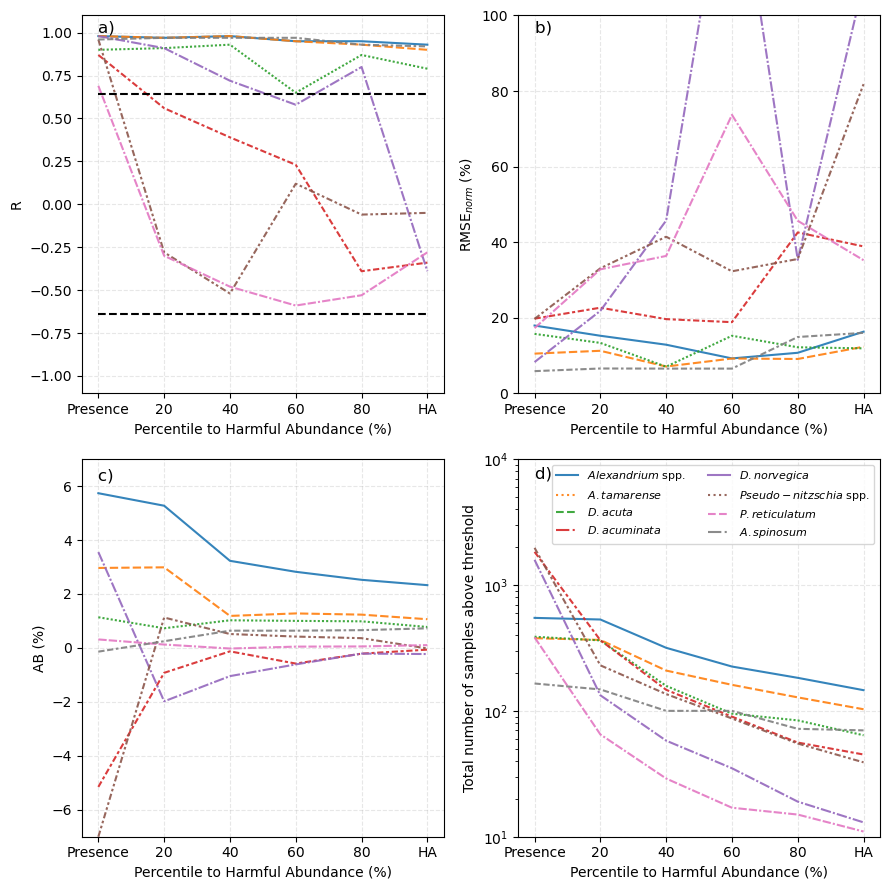

In [27]:
# List of statistics to plot
stat_list = ["R", "RMSE_norm", "AB", "Event frequency"]

# Create a figure
fig, axes = plt.subplots(2, 2, figsize=(9, 9))

# Iterate over each statistic
for i, stat in enumerate(stat_list):
    ax = axes[i // 2, i % 2]  # Select the current subplot

    # Plot the lines for each taxon
    sns.lineplot(
        x="Percentile to HAB",
        y=stat,
        hue="Taxa",
        data=df_habstat,
        style="Taxa",
        legend=(i == 3),
        alpha=0.9,
        ax=ax
    )

    # Edit legend
    if i == 3:
        ax.legend(
            loc='upper right',
            ncol=2,
            fontsize=8,
            handles=handles,
            labels=[
                "$\it{Alexandrium}$ spp.",
                "$\it{A. tamarense}$",
                "$\it{D. acuta}$",
                "$\it{D.acuminata}$",
                "$\it{D. norvegica}$",
                "$\it{Pseudo-nitzschia}$ spp.",
                "$\it{P. reticulatum}$",
                "$\it{A. spinosum}$"
            ]
        )

    # Set axis labels and limits
    ax.set_xlabel("Percentile to Harmful Abundance (%)")
    ax.set_xticklabels(["", "Presence", 20, 40, 60, 80, "HA", ""])
    
    # Customize y-axis based on the statistic
    if stat == "R":
        ax.set_ylim((-1.1, 1.1))
        ax.plot([0, 100], [0.64, 0.64], linestyle="--", color="k")
        ax.plot([0, 100], [-0.64, -0.64], linestyle="--", color="k")
        ax.text(0, 1, chr(ord('`') + i + 1) + ") ", fontsize=12)

    elif stat == "RMSE_norm":
        ax.set_ylim((0, 100))
        ax.text(0, 95.55, chr(ord('`') + i + 1) + ") ", fontsize=12)
        ax.set_ylabel("RMSE$_{norm}$ (%)")

    elif stat == "Event frequency":
        ax.set_yscale("log")
        ax.set_ylim((10, 10000))
        ax.text(0, 7000, chr(ord('`') + i + 1) + ") ", fontsize=12)
        ax.set_ylabel("Total number of samples above threshold")
        
    elif stat == "AB":
        ax.set_ylim((-7, 7))
        ax.text(0, 6.2, chr(ord('`') + i + 1) + ") ", fontsize=12)
        ax.set_ylabel("AB (%)")

    # Add grid
    ax.grid(linestyle="--", alpha=0.3)

# Adjust layout
plt.tight_layout()

# Save figure
fig.savefig(path_out_fig + "/accuracy_response_to_hab.png", dpi=300)
